# Tutorial 2:  Inner Workings of the Selective Knockoff Filter

This tutorial demonstrates the inner workings of the Selective Knockoff Filter (SKF) while testing for interactions with binary covariates.

In [1]:
set.seed(2022)

## Load a toy example data set

In [2]:
suppressMessages(library(tidyverse))
source("../i-modelx/skf.R")

# Load the simulated data set
ifile <- "data/data_n2000_p100_a400-0_i2_delta5_linear_glmnet_b1.txt"
data <- read_delim(ifile, delim=" ", col_types=cols())
X <- select(data, starts_with("X_")) %>% data.matrix()
Y <- select(data, starts_with("Y")) %>% data.matrix() %>% as.numeric()
Z <- select(data, starts_with("Z_")) %>% data.matrix()

# Load the knockoff variables
ifile <- "data/knockoffs_n2000_p100_a400-0_i2_delta5_linear_glmnet_b1.txt"
Xk <- read_delim(ifile, delim=" ", col_types=cols()) %>% select(starts_with("Xk")) %>% data.matrix()

# Load the ground-truth individual treatment effects
ifile <- "data/ite_n2000_p100_a400-0_i2_delta5_linear_glmnet_b1.txt"
ite.data <- read_delim(ifile, delim=" ", col_types=cols()) %>% data.matrix()
ite <- ite.data

# Print basic information about the data
cat(sprintf("This data set contains %d observations of %d binary explanatory variables and %d covariates.\n", length(Y), ncol(X), ncol(Z)))

This data set contains 2000 observations of 20 binary explanatory variables and 80 covariates.


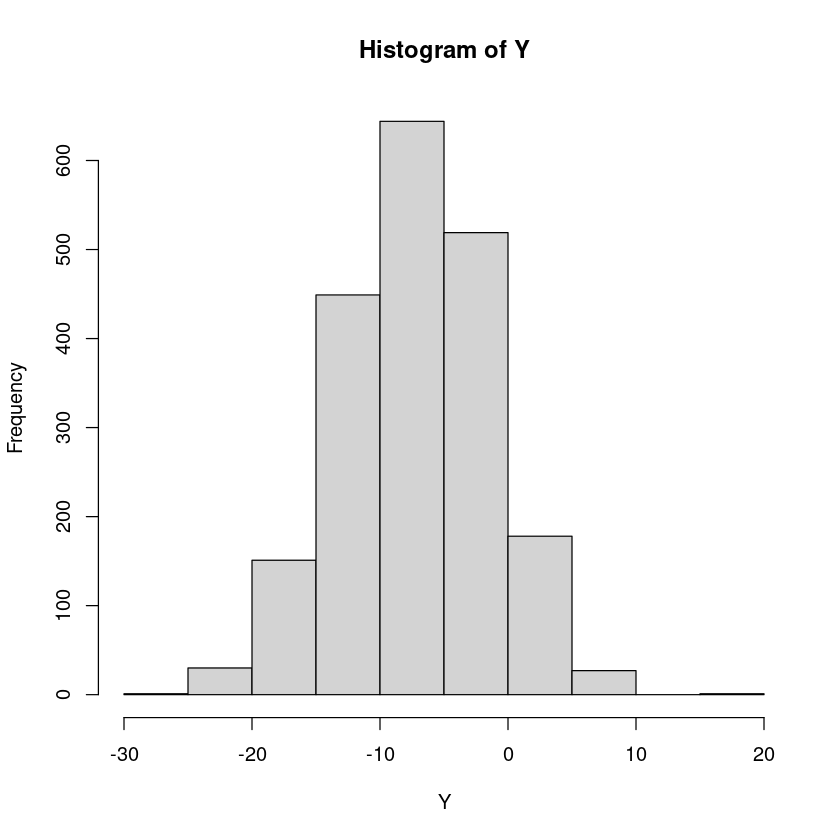

In [3]:
hist(Y)

## Apply the Selective Knockoff Filter

To apply the selective knockoff filter to test for interactions, we begin by specifying which covariates are allowed to interact with the explanatory variables.
In this example, we consider only interactions between the explanatory variables and the binary covariates.

In [4]:
# The first 60 covariates are continuous
Z.noint <- Z[,1:60]

# The remaining 20 covariates are discrete
Z.int <- Z[,61:ncol(Z)]

Below, we will apply the SKF at the nominal 10\% FDR level to detect and test up to 2 different interactions per variable.
However, instead of simply calling the pre-packaged "skf_analysis" as in Tutorial 1, we will carry out manually each step of the analysis.

### Step 1: Partition the covariate space using data with randomly swapped knockoffs

In [5]:
n <- nrow(X)   # Number of observations
N <- ncol(X)   # Number of explanatory variables to be tested
num.int <- 2   # Maximum number of interactions per variable to be tested

## Define the random swapping
V.swap <- matrix(rbinom(n*N,1,1/2), n)

## Partition the covariate space using the lasso with interactions
part.res <- skf_partition_intlasso(Y, X, Xk, Z.noint, Z.int, V.swap, family="gaussian", num.int=num.int, verbose=FALSE)
partition <- part.res$partition

cat(sprintf("Average number of candidate interactions per variable: %.2f.\n", 
           (partition %>% group_by(variable) %>% summarise(n=n()) %>% ungroup() %>% summarise(n=mean(n)))$n))

`summarise()` has grouped output by 'variable', 'covariate'. You can override
using the `.groups` argument.


Average number of candidate interactions per variable: 1.95.


In [6]:
length(part.res$env.list[[1]])

[1] 2000

### Step 2: List the selected hypotheses

In [7]:
## Make the full list of tested hypotheses and check which of them are truly null
hypotheses <- skf_define_hypotheses(partition, part.res$env.list, N, ite=ite)
hypotheses

Variable,Variables,Partition,Label,Null,Causal.prop,Beta.sd,n.sub
<int>,<chr>,<int>,<chr>,<lgl>,<dbl>,<dbl>,<int>
1,"Z_61, Z_68",1,Z_61 : 0; Z_68 : 0,TRUE,0,0,481
1,"Z_61, Z_68",2,Z_61 : 0; Z_68 : 1,TRUE,0,0,487
1,"Z_61, Z_68",3,Z_61 : 1; Z_68 : 0,TRUE,0,0,511
1,"Z_61, Z_68",4,Z_61 : 1; Z_68 : 1,FALSE,1,0,521
2,"Z_63, Z_79",1,Z_63 : 0; Z_79 : 0,TRUE,0,0,492
2,"Z_63, Z_79",2,Z_63 : 0; Z_79 : 1,TRUE,0,0,522
2,"Z_63, Z_79",3,Z_63 : 1; Z_79 : 0,TRUE,0,0,473
2,"Z_63, Z_79",4,Z_63 : 1; Z_79 : 1,FALSE,1,0,513
3,"Z_71, Z_61",1,Z_71 : 0; Z_61 : 0,TRUE,0,0,472


### Step 3: Compute test statistics for each variable in each group

In [8]:
## Compute statistics for each variable in each group
stats <- skf_compute_stats(Y, X, Xk, Z.noint, Z.int, V.swap, partition,
                           family="gaussian", random.swap=TRUE, cross.prior=TRUE, scale.variables=TRUE, verbose=FALSE)

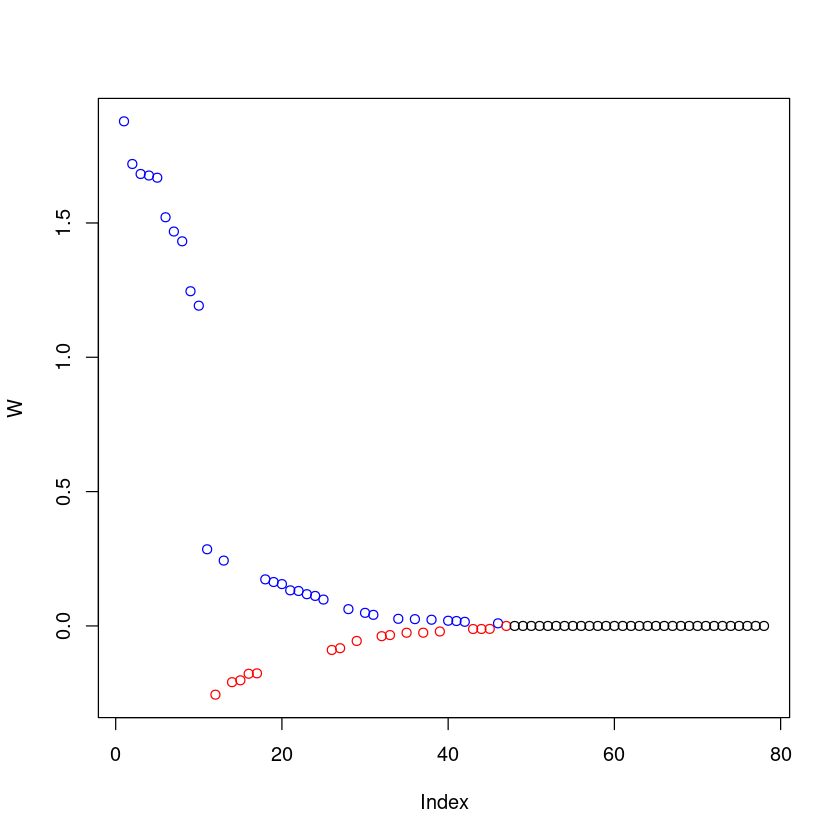

In [9]:
# Plot the test statistics
W <- unlist(stats$W)
W <- W[order(-abs(W))]
W.col <- rep("black", length(W))
W.col[W>0] <- "blue"
W.col[W<0] <- "red"
plot(W, col=W.col)

### Step 4: Filter the test statistics

In [10]:
## Apply the knockoff filter
disc.res <- skf_filter_stats(stats, fdr.nominal=0.1, fdr.offset=1)
discoveries <- disc.res$discoveries
groups <- disc.res$groups

## Evaluate the discoveries

Using our knowledge of the ground-truth individual treatment effects, we can measure the performance of the SKF in terms of power, false discovery proportion (FDP), and homogeneity of the tested hypotheses.

In [11]:
evaluate_results(discoveries, hypotheses)

Offset,FDP,Causal.prop,Beta.sd,Power,True,Discoveries
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.09090909,0.9090909,0,1,10,11


The full list of discoveries reported by the SKF is:

In [12]:
discoveries

Offset,Variable,Partition,W,Label
<dbl>,<int>,<int>,<dbl>,<chr>
1,1,4,1.8782197,Z_61 : 1; Z_68 : 1
1,2,4,1.6765810,Z_63 : 1; Z_79 : 1
1,3,4,1.7194466,Z_71 : 1; Z_61 : 1
1,4,4,1.2458230,Z_74 : 1; Z_66 : 1
1,7,4,1.5211617,Z_77 : 1; Z_63 : 1
1,11,4,1.6683667,Z_69 : 1; Z_77 : 1
1,13,2,0.2852935,Z_78 : 0; Z_75 : 1
1,13,4,1.4680500,Z_78 : 1; Z_75 : 1
1,14,4,1.1919779,Z_67 : 1; Z_75 : 1
